In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import agent as ag
import df_helpers as dfh
import model as ml

from matplotlib import style

from google_window import WindowGenerator
from model import get_lstm_model
# style.use('dark_background')

import importlib
importlib.reload(ag)
importlib.reload(ml)
importlib.reload(dfh)

<module 'df_helpers' from '/home/jupyter/src/Project 3/IT3030-Projects/Project 3/df_helpers.py'>

In [2]:
# Open no1_train.csv and no1_validation.csv
original_df_train = pd.read_csv('no1_train.csv')
original_df_test = pd.read_csv('no1_validation.csv')

# Make copies
df_train = original_df_train.copy()
df_test = original_df_test.copy()

In [3]:
df_train

,start_time,hydro,micro,thermal,wind,river,total,y,sys_reg,flow
0,2019-01-09 14:10:00,1591.839,141.928,11.5,74.428,0.0,1819.695,341.330021,10.0,-4417.4
1,2019-01-09 14:15:00,1591.839,141.928,11.5,74.428,0.0,1819.695,330.114330,10.0,-4417.4
2,2019-01-09 14:20:00,1591.839,141.928,11.5,74.428,0.0,1819.695,323.877221,10.0,-4417.4
3,2019-01-09 14:25:00,1591.839,141.928,11.5,74.428,0.0,1819.695,296.438463,10.0,-4417.4
4,2019-01-09 14:30:00,1591.839,141.928,11.5,74.428,0.0,1819.695,269.097132,10.0,-4417.4
...,...,...,...,...,...,...,...,...,...,...
225083,2021-03-01 03:05:00,1942.486,191.881,20.1,106.431,0.0,2266.098,141.618915,0.0,-2252.9
225084,2021-03-01 03:10:00,1942.486,191.881,20.1,106.431,0.0,2266.098,129.043820,0.0,-2252.9
225085,2021-03-01 03:15:00,1942.486,191.881,20.1,106.431,0.0,2266.098,94.907548,0.0,-2252.9
225086,2021-03-01 03:20:00,1942.486,191.881,20.1,106.431,0.0,2266.098,102.589040,0.0,-2252.9


In [4]:
df_test.head()

,start_time,hydro,micro,thermal,wind,river,total,y,sys_reg,flow
0,2021-03-01 03:30:00,1942.49,191.881,20.1,106.431,0.0,2266.102,52.119595,0.0,-2252.9
1,2021-03-01 03:35:00,1942.49,191.881,20.1,106.431,0.0,2266.102,90.374541,0.0,-2252.9
2,2021-03-01 03:40:00,1942.49,191.881,20.1,106.431,0.0,2266.102,88.435063,0.0,-2252.9
3,2021-03-01 03:45:00,1942.49,191.881,20.1,106.431,0.0,2266.102,53.375518,0.0,-2252.9
4,2021-03-01 03:50:00,1942.49,191.881,20.1,106.431,0.0,2266.102,65.496683,0.0,-2252.9


In [5]:
# Convert timestamps in "start_time" to seconds
df_train['start_time_seconds'] = pd.to_datetime(df_train['start_time'])
df_train['start_time_seconds'] = df_train['start_time_seconds'].apply(lambda x: x.timestamp())

# Do the same to df_test
df_test['start_time_seconds'] = pd.to_datetime(df_test['start_time'])
df_test['start_time_seconds'] = df_test['start_time_seconds'].apply(lambda x: x.timestamp())

## Exploratory Data Analysis

First let's look at the data and see if we notice any outliers that might not correlate well with the overall trend of the data

In [6]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
hydro,225088.0,1.888334e+03,4.010003e+02,6.834380e+02,1.625029e+03,1.933916e+03,2.175595e+03,2.995524e+03
micro,225088.0,2.241898e+02,5.855985e+01,8.037100e+01,1.850170e+02,2.259380e+02,2.695580e+02,3.492710e+02
thermal,225088.0,2.180350e+01,3.579229e+00,0.000000e+00,2.210000e+01,2.210000e+01,2.410000e+01,2.570000e+01
wind,225088.0,5.570327e+01,4.705303e+01,0.000000e+00,1.570400e+01,4.184800e+01,8.872300e+01,1.760000e+02
river,225088.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
total,225088.0,2.190032e+03,4.440777e+02,8.497320e+02,1.916523e+03,2.248874e+03,2.497792e+03,3.351974e+03
y,225088.0,8.907921e+00,3.202625e+02,-1.579681e+03,-1.422267e+02,-1.128235e+01,1.274549e+02,2.956333e+03
sys_reg,225088.0,-8.284305e+00,4.374831e+01,-8.280000e+02,0.000000e+00,0.000000e+00,0.000000e+00,4.740000e+02
flow,225088.0,-1.999055e+03,1.311682e+03,-5.541200e+03,-2.996700e+03,-1.953700e+03,-9.069000e+02,7.234000e+02
start_time_seconds,225088.0,1.580806e+09,1.949324e+07,1.547043e+09,1.563925e+09,1.580806e+09,1.597688e+09,1.614569e+09


Seeing as river has absolutely all values equal to 0, this is not a good feature to use. We therefore drop it because
it gives no additional information. We will also drop sysreg since it seems this feature too is very monotonous, and does not yield much information.

In [7]:
df_train = df_train.drop(['river'], axis=1)
df_test = df_test.drop(['river'], axis=1)

df_train = df_train.drop(['sys_reg'], axis=1)
df_test = df_test.drop(['sys_reg'], axis=1)

Let's visualize the data in several plots to see if we instinctively can see anything that doesn't add up

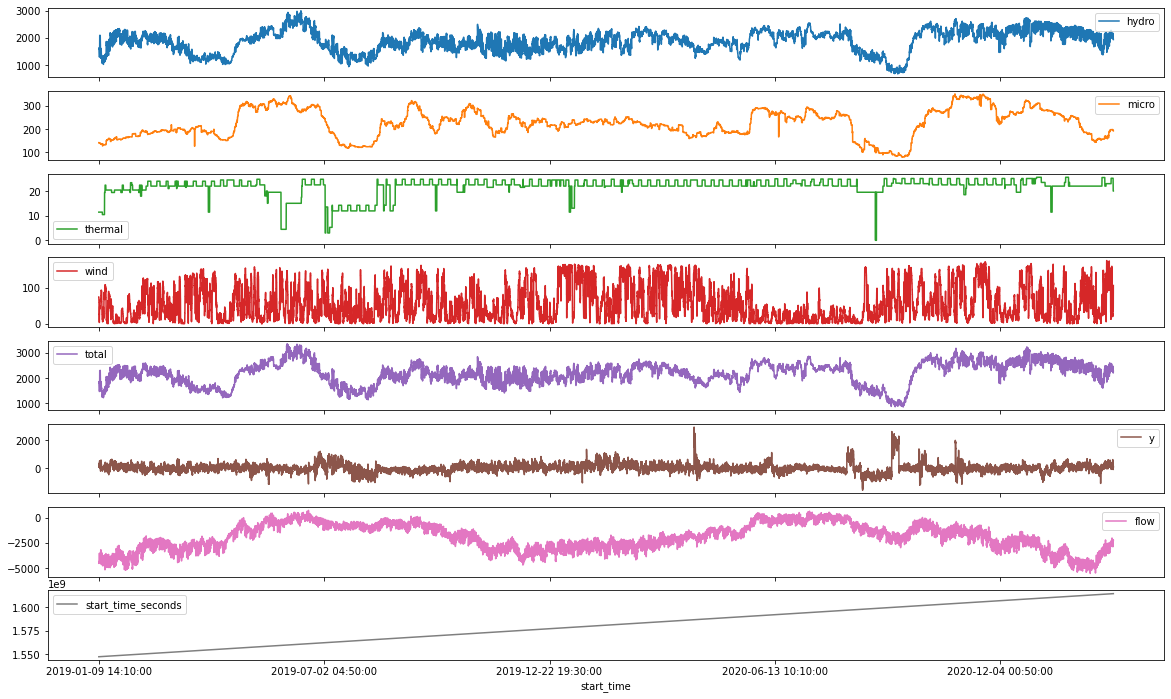

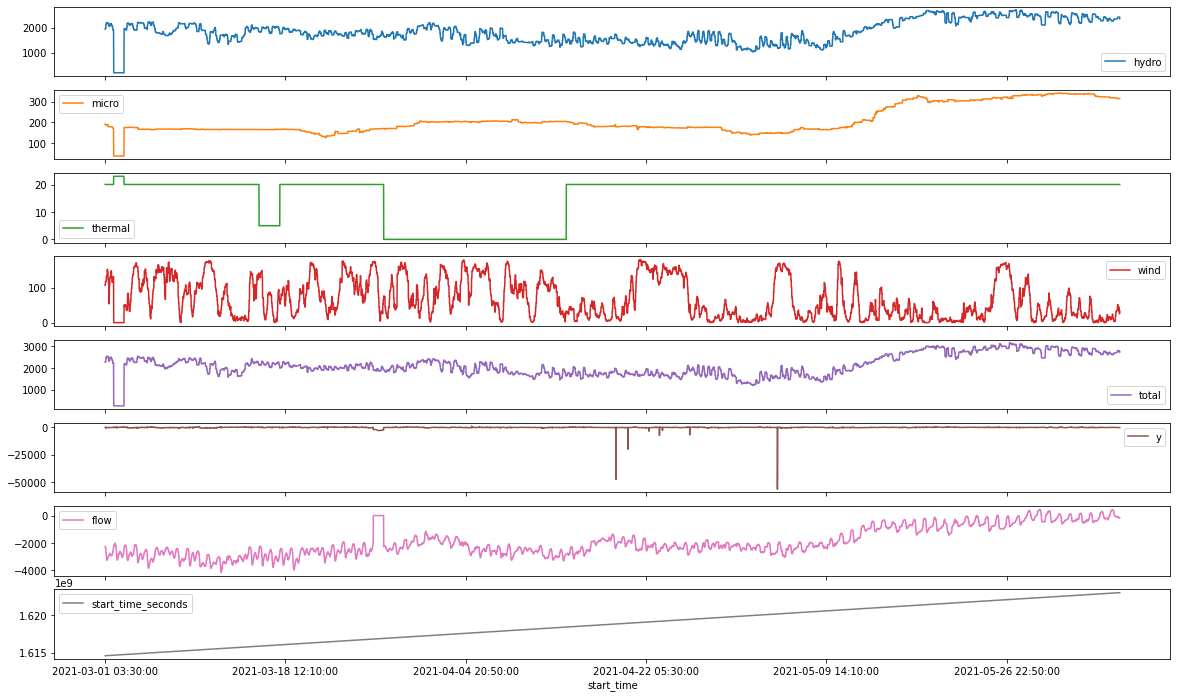

In [8]:
# Get column names from df_train except start_time
cols = df_train.columns.drop('start_time')
plot_features = df_train[cols]
plot_features.index = df_train['start_time']
_ = plot_features.plot(subplots=True, figsize=(20, 12))

# Do the same for df_test
plot_features = df_test.drop("start_time", axis=1)[cols]
plot_features.index = df_test['start_time']
_ = plot_features.plot(subplots=True, figsize=(20, 12))

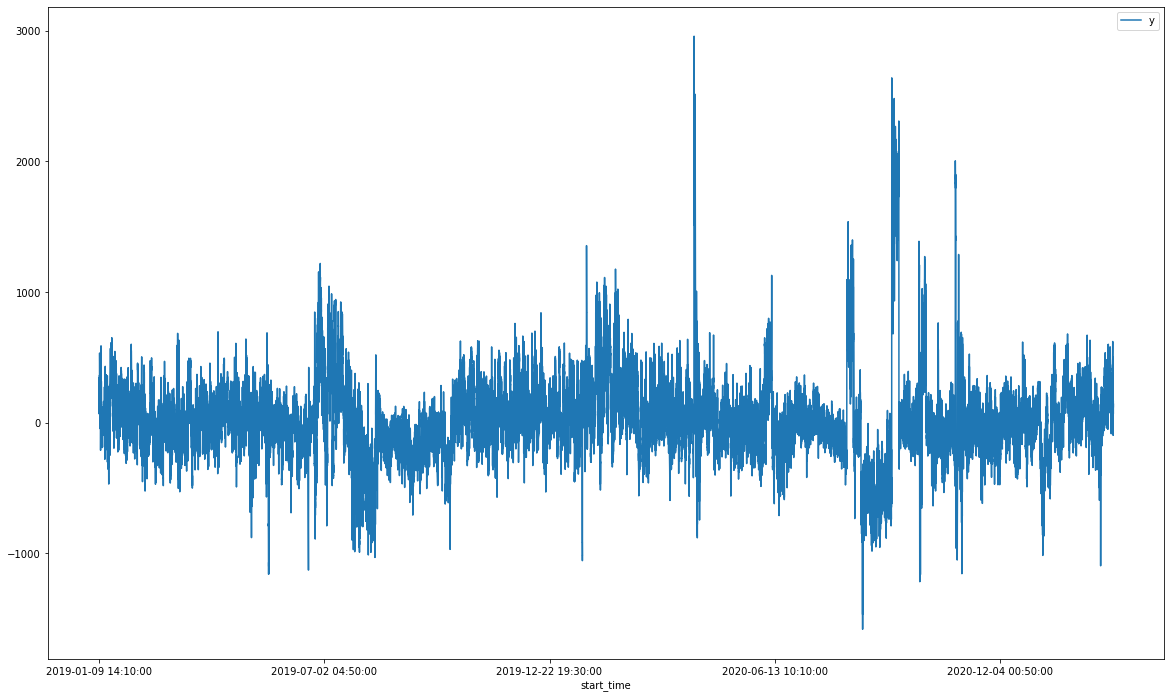

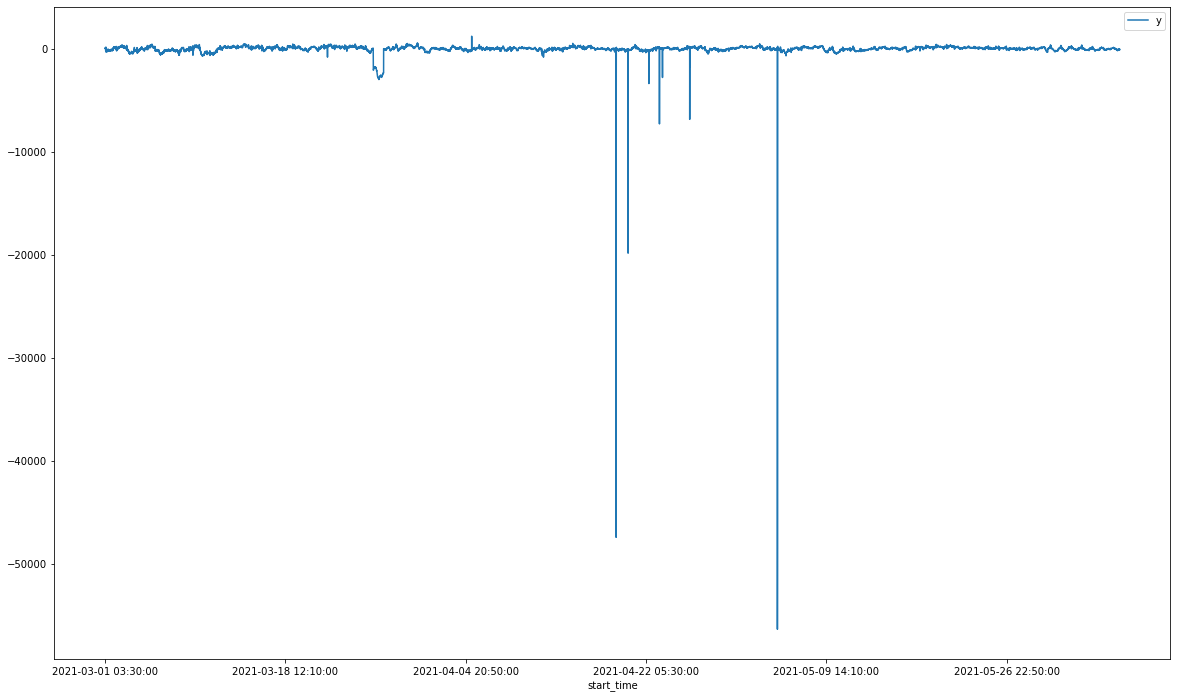

In [9]:
# Plot two different plots; one for df_train, one for df_test with feature "y"
plot_features = df_train[['y']]
plot_features.index = df_train['start_time']
_ = plot_features.plot(subplots=True, figsize=(20, 12))

# Do the same for df_test, but in a new plot 
plot_features = df_test[['y']]
plot_features.index = df_test['start_time']
_ = plot_features.plot(subplots=True, figsize=(20, 12))


There are some spikes in both datasets, especially the validation data, that seem rather inconsistent. Let's replace them with values based on the mean of the "y" value for other datapoints that have similar "total" feature.

In [10]:
df1 = dfh.get_rows_between(df_train, 'total', 1500, 1550)
df2 = dfh.get_rows_between(df1, 'y', -2900, 2900)
mean_val = df2["y"].mean()
q = (df_train["y"] > 1500) | (df_train["y"] < -1500)
n_clamps = df_train.loc[q].shape[0]
print(f"Percentage of rows clamped in training: {round(n_clamps / df_train.shape[0], 2) * 100}%")
df_train.loc[q, "y"] = mean_val

# Do the same for df_test
df1 = dfh.get_rows_between(df_test, 'total', 1500, 1550)
df2 = dfh.get_rows_between(df1, 'y', -2900, 2900)
mean_val = df2["y"].mean()
q = (df_test["y"] > 1500) | (df_test["y"] < -1500)
n_clamps = df_test.loc[q].shape[0]
print(f"Percentage of rows clamped in testing: {round(n_clamps / df_test.shape[0], 2) * 100}%")
df_test.loc[q, "y"] = mean_val

Percentage of rows clamped in training: 1.0%
Percentage of rows clamped in testing: 1.0%


Let's see if there are any NaN-values present

In [11]:
# Check for NaN values
df_train.isnull().sum()

start_time            0
hydro                 0
micro                 0
thermal               0
wind                  0
total                 0
y                     0
flow                  0
start_time_seconds    0
dtype: int64

## Feature engineering
In this section, we will look at how we can manipulate the data in the dataset in order to better suit it for model prediction. This will include modifying existing features, and introducing new ones.

First we'll implement the required feature: previous_y

Second we'll look at frequencies.
The nature of demand on the power grid is highly dependent on two key factors:
* The time of day
* The time of year

Seeing as the price of electricity has been a heated debate for the past half-year due to environmental and seasonal changes, this might be a good place to start.

In [12]:
day = 24*60*60
year = (365.2425)*day

df_train['Day sin'] = np.sin(df_train['start_time_seconds'] * (2 * np.pi / day))
df_train['Day cos'] = np.cos(df_train['start_time_seconds'] * (2 * np.pi / day))
df_train['Year sin'] = np.sin(df_train['start_time_seconds'] * (2 * np.pi / year))
df_train['Year cos'] = np.cos(df_train['start_time_seconds'] * (2 * np.pi / year))

# Do the same, but for df_test
df_test['Day sin'] = np.sin(df_test['start_time_seconds'] * (2 * np.pi / day))
df_test['Day cos'] = np.cos(df_test['start_time_seconds'] * (2 * np.pi / day))
df_test['Year sin'] = np.sin(df_test['start_time_seconds'] * (2 * np.pi / year))
df_test['Year cos'] = np.cos(df_test['start_time_seconds'] * (2 * np.pi / year))


Let's also add simple bucket-indicators for the time of day since this massively impacts the use of the power grid.
We will use the following buckets for the feature 'time_of_day':

* 0 = early morning. Times between 06:00 and 09:00
* 1 = late morning. Times between 09:00 and 12:00
* 2 = early day. Times between 12:00 and 15:00
* 3 = evening. Times between 15:00 and 18:00
* 4 = late evening. Times between 18:00 and 21:00
* 5 = early night. Times between 21:00 and 00:00
* 6 = night time. Times between 00:00 and 06:00

In [13]:
df_train['hours'] = pd.to_datetime(df_train['start_time']).apply(lambda x: x.hour)
df_train['time_of_day'] = 0
# If time_of_day is between 6 and 8, set it to 0
df_train.loc[(df_train['hours'] >= 6) & (df_train['hours'] <= 8), 'time_of_day'] = 0
# If between 9 and 11, set it to 1
df_train.loc[(df_train['hours'] >= 9) & (df_train['hours'] <= 11), 'time_of_day'] = 1
# If between 12 and 14, set it to 2
df_train.loc[(df_train['hours'] >= 12) & (df_train['hours'] <= 14), 'time_of_day'] = 2
# If between 15 and 17, set it to 3
df_train.loc[(df_train['hours'] >= 15) & (df_train['hours'] <= 17), 'time_of_day'] = 3
# If between 18 and 20, set it to 4
df_train.loc[(df_train['hours'] >= 18) & (df_train['hours'] <= 20), 'time_of_day'] = 4
# If between 21 and 23, set it to 5
df_train.loc[(df_train['hours'] >= 21) & (df_train['hours'] <= 23), 'time_of_day'] = 5
# If between 0 and 5, set it to 6
df_train.loc[(df_train['hours'] >= 0) & (df_train['hours'] <= 5), 'time_of_day'] = 6
df_train.drop(columns='hours', inplace=True)

# Do the same for df_test
df_test['hours'] = pd.to_datetime(df_test['start_time']).apply(lambda x: x.hour)
df_test['time_of_day'] = 0
df_test.loc[(df_test['hours'] >= 6) & (df_test['hours'] <= 8), 'time_of_day'] = 0
df_test.loc[(df_test['hours'] >= 9) & (df_test['hours'] <= 11), 'time_of_day'] = 1
df_test.loc[(df_test['hours'] >= 12) & (df_test['hours'] <= 14), 'time_of_day'] = 2
df_test.loc[(df_test['hours'] >= 15) & (df_test['hours'] <= 17), 'time_of_day'] = 3
df_test.loc[(df_test['hours'] >= 18) & (df_test['hours'] <= 20), 'time_of_day'] = 4
df_test.loc[(df_test['hours'] >= 21) & (df_test['hours'] <= 23), 'time_of_day'] = 5
df_test.loc[(df_test['hours'] >= 0) & (df_test['hours'] <= 5), 'time_of_day'] = 6
df_test.drop(columns='hours', inplace=True)

Now we will apply the same logic for time_of_week, however we will have to use different buckets. We'll simply add one bucket for each day of the week, i.e. 0 for monday, 1 for tuesday, etc..
We will also add an arbitrary feature called 'weekend', which will apply to saturday and sunday (1 for 'weekend' = True, else 0)

In [14]:
df_train['time_of_week'] = pd.to_datetime(df_train['start_time']).apply(lambda x: x.weekday())
# If time_of_week = 5 or 6, set feature 'weekend' to 1. Else set to 0
df_train['weekend'] = 0
df_train.loc[(df_train['time_of_week'] == 5) | (df_train['time_of_week'] == 6), 'weekend'] = 1

# Do the same for df_test
df_test['time_of_week'] = pd.to_datetime(df_test['start_time']).apply(lambda x: x.weekday())
df_test['weekend'] = 0
df_test.loc[(df_test['time_of_week'] == 5) | (df_test['time_of_week'] == 6), 'weekend'] = 1

Finally, we get to time_of_year. Here we will simply use the different months that the dates correspond to. Using this, we will also add a feature called 'season' to explicitly state whether we are in the summer, winter, autumn, or spring.
We will bucket the season as follows using [this](https://snl.no/%C3%A5rstider) definition:

* Spring will go from March through May
* Summer will start in June, and end with (including) August
* Autumn then starts from September, and runs until November
* Finally, winter runs from December through February

In [15]:
df_train['time_of_year'] = pd.to_datetime(df_train['start_time']).apply(lambda x: x.month)
df_train['season'] = 0
# If time_of_year is between 3 and 5, set it to 0
df_train.loc[(df_train['time_of_year'] >= 3) & (df_train['time_of_year'] <= 5), 'season'] = 0
# If between 6 and 8, set it to 1
df_train.loc[(df_train['time_of_year'] >= 6) & (df_train['time_of_year'] <= 8), 'season'] = 1
# If between 9 and 11, set it to 2
df_train.loc[(df_train['time_of_year'] >= 9) & (df_train['time_of_year'] <= 11), 'season'] = 2
# If between 12 and 2, set it to 3
df_train.loc[df_train['time_of_year'] == 12, 'season'] = 3
df_train.loc[df_train['time_of_year'] <= 2, 'season'] = 3

# Do the same for df_test
df_test['time_of_year'] = pd.to_datetime(df_test['start_time']).apply(lambda x: x.month)
df_test['season'] = 0
df_test.loc[(df_test['time_of_year'] >= 3) & (df_test['time_of_year'] <= 5), 'season'] = 0
df_test.loc[(df_test['time_of_year'] >= 6) & (df_test['time_of_year'] <= 8), 'season'] = 1
df_test.loc[(df_test['time_of_year'] >= 9) & (df_test['time_of_year'] <= 11), 'season'] = 2
df_test.loc[df_test['time_of_year'] == 12, 'season'] = 3
df_test.loc[df_test['time_of_year'] <= 2, 'season'] = 3

We don't need the features that give us the time in raw values anymore, therefore we remove them.

In [16]:
df_train.drop(columns=['start_time', 'start_time_seconds'], inplace=True)
df_test.drop(columns=['start_time', 'start_time_seconds'], inplace=True)

In [17]:
df_train.head()

,hydro,micro,thermal,wind,total,y,flow,Day sin,Day cos,Year sin,Year cos,time_of_day,time_of_week,weekend,time_of_year,season
0,1591.839,141.928,11.5,74.428,1819.695,341.330021,-4417.4,-0.537300,-0.843391,0.149238,0.988801,2,2,0,1,3
1,1591.839,141.928,11.5,74.428,1819.695,330.114330,-4417.4,-0.555570,-0.831470,0.149297,0.988792,2,2,0,1,3
2,1591.839,141.928,11.5,74.428,1819.695,323.877221,-4417.4,-0.573576,-0.819152,0.149356,0.988783,2,2,0,1,3
3,1591.839,141.928,11.5,74.428,1819.695,296.438463,-4417.4,-0.591310,-0.806445,0.149416,0.988774,2,2,0,1,3
4,1591.839,141.928,11.5,74.428,1819.695,269.097132,-4417.4,-0.608761,-0.793353,0.149475,0.988766,2,2,0,1,3


Finally, we add one-hot encoding of these variables to make the dataframe more sparse

In [18]:
# One-hot encode the columns with time_of_day, time_of_week, time_of_year, and season
one_hot_feats = ['time_of_day', 'time_of_week', 'time_of_year', 'season']
df_train = pd.get_dummies(df_train, columns=one_hot_feats)
df_test = pd.get_dummies(df_test, columns=one_hot_feats)

In [19]:
# The following features did not get added to df_test since they are not observed, therefore they must be added manually
diff_feats = [a for a in df_train.columns if a not in df_test.columns]
df_test[diff_feats] = 0

Let's now just add a bunch of lagged variables. This is mainly because the model seems to heavily weight the data from the very near past, so let's just try to reinforce this

In [20]:
# Add a column which shifts 'total' by 24 hours
df_train = dfh.add_shift(df_train, 'total', 24)
df_train = dfh.add_shift(df_train, 'total', 12)
df_train = dfh.add_shift(df_train, 'total', 6)
# Do the same for feature 'flow'
df_train = dfh.add_shift(df_train, 'flow', 24)
df_train = dfh.add_shift(df_train, 'flow', 12)
df_train = dfh.add_shift(df_train, 'flow', 6)

# Do the same for df_test
df_test = dfh.add_shift(df_test, 'total', 24)
df_test = dfh.add_shift(df_test, 'total', 12)
df_test = dfh.add_shift(df_test, 'total', 6)
# Do the same for feature 'flow'
df_test = dfh.add_shift(df_test, 'flow', 24)
df_test = dfh.add_shift(df_test, 'flow', 12)
df_test = dfh.add_shift(df_test, 'flow', 6)

We will now add the feature 'previous_y', which is the imbalance from the previous timestep. We will then use this value to add a rolling average for the last 24, 12, 6, and 3 hours, meaning we get 4 additional features that measure the average 'previous_y' value based on those previous hour segments.

Note that unlike ```add_shift```, ```add_shifted_target``` shifts by 1 hard-coded index, rather than a variable number of hours (this is why they are 2 different functions).

In [21]:
df_train = dfh.add_shifted_target(df_train, 'y')
df_test = dfh.add_shifted_target(df_test, 'y')

df_train = dfh.add_rolling_avg(df_train, 'previous_y', hours=24)
df_train = dfh.add_rolling_avg(df_train, 'previous_y', hours=12)
df_train = dfh.add_rolling_avg(df_train, 'previous_y', hours=6)
df_train = dfh.add_rolling_avg(df_train, 'previous_y', hours=3)

#dftest
df_test = dfh.add_rolling_avg(df_test, 'previous_y', hours=24)
df_test = dfh.add_rolling_avg(df_test, 'previous_y', hours=12)
df_test = dfh.add_rolling_avg(df_test, 'previous_y', hours=6)
df_test = dfh.add_rolling_avg(df_test, 'previous_y', hours=3)

In [22]:
RESOLUTION = 5
N_PREV = 24
START_INDEX = 300
BATCH_SIZE = 64
TARGET = 'y'
EPOCHS = 300
agent = ag.Agent(
    min_scale=-1,
    max_scale=1,
    resolution=RESOLUTION,
    n_prev=N_PREV,
    start_index=START_INDEX,
    batch_size=BATCH_SIZE,
    target=TARGET,
    verbose=True,
    model=get_lstm_model(),
    filepath='./models/LSTM_model_1',
)

Resolution is 5 and n_prev is 48. This is equivalent to looking back 4 hours and 0 minutes. 


2022-04-25 19:35:16.939819: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 19:35:16.949421: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 19:35:16.950083: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 19:35:16.951019: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [23]:
agent.fit_scalers(df_train)
df_train = agent.transform(df_train)
df_test = agent.transform(df_test)

In [24]:
df_test.head()

,hydro,micro,thermal,wind,total,y,flow,Day sin,Day cos,Year sin,...,total_shift_12,total_shift_6,flow_shift_24,flow_shift_12,flow_shift_6,previous_y,previous_y_avg_prev_24h,previous_y_avg_prev_12h,previous_y_avg_prev_6h,previous_y_avg_prev_3h
0,0.089105,-0.170621,0.564202,0.209443,0.132081,0.028026,0.049804,0.793353,0.608761,0.856450,...,-1.0,-1.0,0.769051,0.769051,0.769051,-0.006972,-0.075197,-0.191713,-0.107709,-0.096252
1,0.089105,-0.170621,0.564202,0.209443,0.132081,0.053714,0.049804,0.806445,0.591310,0.856481,...,-1.0,-1.0,0.769051,0.769051,0.769051,0.028026,-0.075197,-0.191713,-0.107709,-0.096252
2,0.089105,-0.170621,0.564202,0.209443,0.132081,0.052411,0.049804,0.819152,0.573576,0.856512,...,-1.0,-1.0,0.769051,0.769051,0.769051,0.053714,-0.075197,-0.191713,-0.107709,-0.096252
3,0.089105,-0.170621,0.564202,0.209443,0.132081,0.028869,0.049804,0.831470,0.555570,0.856543,...,-1.0,-1.0,0.769051,0.769051,0.769051,0.052411,-0.075197,-0.191713,-0.107709,-0.096252
4,0.089105,-0.170621,0.564202,0.209443,0.132081,0.037008,0.049804,0.843391,0.537300,0.856573,...,-1.0,-1.0,0.769051,0.769051,0.769051,0.028869,-0.075197,-0.191713,-0.107709,-0.096252


In [25]:
df_train.head()

,hydro,micro,thermal,wind,total,y,flow,Day sin,Day cos,Year sin,...,total_shift_12,total_shift_6,flow_shift_24,flow_shift_12,flow_shift_6,previous_y,previous_y_avg_prev_24h,previous_y_avg_prev_12h,previous_y_avg_prev_6h,previous_y_avg_prev_3h
0,-0.214215,-0.542157,-0.105058,-0.154227,-0.224725,0.222227,-0.641222,-0.537300,-0.843391,0.149238,...,-1.0,-1.0,0.769051,0.769051,0.769051,-0.006972,-0.075197,-0.191713,-0.107709,-0.096252
1,-0.214215,-0.542157,-0.105058,-0.154227,-0.224725,0.214696,-0.641222,-0.555570,-0.831470,0.149297,...,-1.0,-1.0,0.769051,0.769051,0.769051,0.222227,-0.075197,-0.191713,-0.107709,-0.096252
2,-0.214215,-0.542157,-0.105058,-0.154227,-0.224725,0.210508,-0.641222,-0.573576,-0.819152,0.149356,...,-1.0,-1.0,0.769051,0.769051,0.769051,0.214696,-0.075197,-0.191713,-0.107709,-0.096252
3,-0.214215,-0.542157,-0.105058,-0.154227,-0.224725,0.192083,-0.641222,-0.591310,-0.806445,0.149416,...,-1.0,-1.0,0.769051,0.769051,0.769051,0.210508,-0.075197,-0.191713,-0.107709,-0.096252
4,-0.214215,-0.542157,-0.105058,-0.154227,-0.224725,0.173724,-0.641222,-0.608761,-0.793353,0.149475,...,-1.0,-1.0,0.769051,0.769051,0.769051,0.192083,-0.075197,-0.191713,-0.107709,-0.096252


In [26]:
assert(all([a in df_train.columns for a in df_test.columns]))

In [27]:
# Here one can drop features to see if the model improves with less features
# df_train.drop(columns=['Day sin', 'Day cos', 'Year sin', 'Year cos'], inplace=True)

In [28]:
history = agent.train(df_train, epochs=EPOCHS)


===== CALLING MAKE_DATASET =====
Processing chunk 0
Processing chunk 40000
Processing chunk 30000
Processing chunk 20000
Processing chunk 50000
Processing chunk 10000
Processing chunk 60000
Processing chunk 80000
Processing chunk 70000
Processing chunk 90000
Processing chunk 130000
Processing chunk 120000
Processing chunk 110000
Processing chunk 100000
Processing chunk 150000
Processing chunk 160000
Processing chunk 140000Processing chunk 170000
Processing chunk 200000

Processing chunk 190000
Processing chunk 220000
Processing chunk 180000
Processing chunk 210000
Finished making dataset.



2022-04-25 19:35:43.986633: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2246789376 exceeds 10% of free system memory.
2022-04-25 19:35:45.424374: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2246789376 exceeds 10% of free system memory.


Epoch 1/20


2022-04-25 19:35:49.867319: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


7027/7033 [============================>.] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.0347
Epoch 1: saving model to ./models/LSTM_model_1
7033/7033 [==============================] - 55s 7ms/step - loss: 0.0031 - mean_absolute_error: 0.0347
Epoch 2/20
7033/7033 [==============================] - ETA: 0s - loss: 9.1814e-04 - mean_absolute_error: 0.0173
Epoch 2: saving model to ./models/LSTM_model_1
7033/7033 [==============================] - 50s 7ms/step - loss: 9.1814e-04 - mean_absolute_error: 0.0173
Epoch 3/20
7029/7033 [============================>.] - ETA: 0s - loss: 7.5186e-04 - mean_absolute_error: 0.0149
Epoch 3: saving model to ./models/LSTM_model_1
7033/7033 [==============================] - 51s 7ms/step - loss: 7.5173e-04 - mean_absolute_error: 0.0149
Epoch 4/20
7029/7033 [============================>.] - ETA: 0s - loss: 6.7849e-04 - mean_absolute_error: 0.0138
Epoch 4: saving model to ./models/LSTM_model_1
7033/7033 [==============================] - 50s 7ms/step 

KeyboardInterrupt: 

In [ ]:
loss_per_epoch = history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
x_valid = df_test.drop("y", axis=1)
x_valid.head()

In [ ]:
y_pred = agent.predict_n_timesteps(df=x_valid, n_timesteps=1000, replace=True)
y_true = agent.scalers['y'].inverse_transform(df_test['y'].to_numpy().reshape(-1,1))
agent.visualize_results(y_true, y_pred, n_timesteps=1000)